In [4]:
!pip install tensorflow numpy pandas matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
# Load the dataset
data = pd.read_csv(r"C:\Users\Sathvik\OneDrive\Desktop\SPAM text message 20170820 - Data.csv")
# Display the first 5 rows
print(data.head())

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


Category
ham     4825
spam     747
Name: count, dtype: int64


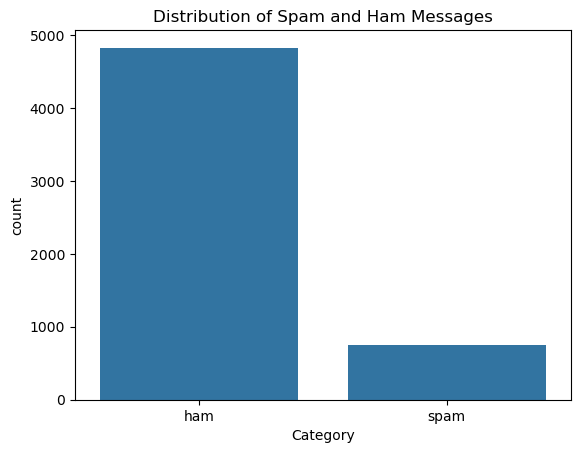


Balanced Dataset Distribution:
Category
ham     747
spam    747
Name: count, dtype: int64


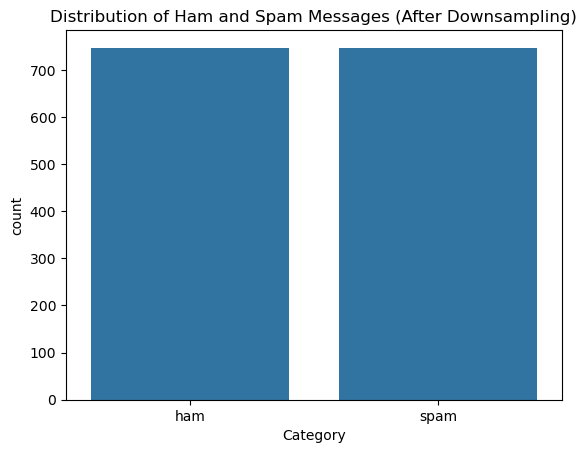

In [11]:
# Check the distribution of spam and ham messages
print(data['Category'].value_counts())

# Visualize the distribution
sns.countplot(x='Category', data=data)
plt.title('Distribution of Spam and Ham Messages')
plt.show()

# Downsample the 'ham' messages to balance the dataset
ham_msg = data[data.Category == 'ham']
spam_msg = data[data.Category == 'spam']

# Randomly sample 'ham' messages to match the number of 'spam' messages
ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combine the balanced ham and spam messages
balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)

# Display the new distribution
print("\nBalanced Dataset Distribution:")
print(balanced_data['Category'].value_counts())

# Visualize the balanced distribution
sns.countplot(x='Category', data=balanced_data)
plt.title('Distribution of Ham and Spam Messages (After Downsampling)')
plt.show()

In [12]:
# Map 'ham' to 0 and 'spam' to 1
balanced_data['label'] = balanced_data['Category'].map({'ham': 0, 'spam': 1})

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    balanced_data['Message'],
    balanced_data['label'],
    test_size=0.2,
    random_state=42,
    stratify=balanced_data['label'] # Ensures balanced split
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (1195,)
Testing data shape: (299,)


In [13]:
# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure they all have the same length
max_len = 100  # We'll make sure every message is 100 words long
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

print("\nSample of a padded training sequence:")
print(train_sequences[0])


Sample of a padded training sequence:
[   2   22    3  343    8   18   77  663  214   12  148  153   57   15
    3   24  157 1260  664  299    1    3  162  380   12   37 1943    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [14]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # Sigmoid for binary classification

# Print the model summary
model.summary()

C:\Users\Sathvik\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_sequences,
    y_train,
    validation_data=(test_sequences, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.4895 - loss: 0.6939 - val_accuracy: 0.5017 - val_loss: 0.6931
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4996 - loss: 0.6933 - val_accuracy: 0.5017 - val_loss: 0.6931
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4996 - loss: 0.6933 - val_accuracy: 0.5017 - val_loss: 0.6932
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4644 - loss: 0.6935 - val_accuracy: 0.5017 - val_loss: 0.6931
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4921 - loss: 0.6934 - val_accuracy: 0.4983 - val_loss: 0.6932
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4787 - loss: 0.6936 - val_accuracy: 0.4983 - val_loss: 0.6932
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4879 - loss: 0.6933 - val_accuracy: 0.5017 - val_loss: 0.6931
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4996 - loss: 0.6933 - val_accuracy: 0.4983 - v

In [16]:
# --- NEW, MORE POWERFUL MODEL ---
# We're making the model more powerful to help it find the patterns.

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_len))
model.add(tf.keras.layers.LSTM(64)) # Increased from 16 to 64
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the new model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile the new model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the new model
history = model.fit(
    train_sequences,
    y_train,
    validation_data=(test_sequences, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4695 - loss: 0.6947 - val_accuracy: 0.5017 - val_loss: 0.6931
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5004 - loss: 0.6933 - val_accuracy: 0.4983 - val_loss: 0.6932
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4962 - loss: 0.6935 - val_accuracy: 0.5017 - val_loss: 0.6931
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4983 - val_loss: 0.6932
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5004 - loss: 0.6933 - val_accuracy: 0.4983 - val_loss: 0.6932
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4803 - loss: 0.6932 - val_accuracy: 0.4983 - val_loss: 0.6932
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4669 - loss: 0.6934 - val_accuracy: 0.4983 - val_loss: 0.6932
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5004 - loss: 0.6932 - val_accuracy: 0.4983 - v

In [18]:
# --- NEW ADVANCED MODEL (Bidirectional) ---

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_len))

# Use a Bidirectional LSTM layer
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))

# Add a Dropout layer for regularization
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the new model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Compile the new model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the new model
history = model.fit(
    train_sequences,
    y_train,
    validation_data=(test_sequences, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.7414 - loss: 0.5380 - val_accuracy: 0.8930 - val_loss: 0.3291
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9498 - loss: 0.1570 - val_accuracy: 0.9532 - val_loss: 0.1197
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9824 - loss: 0.0741 - val_accuracy: 0.9732 - val_loss: 0.1039
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9891 - loss: 0.0480 - val_accuracy: 0.9666 - val_loss: 0.0992
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9941 - loss: 0.0260 - val_accuracy: 0.9599 - val_loss: 0.1127
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9941 - loss: 0.0161 - val_accuracy: 0.9599 - val_loss: 0.1259
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9958 - loss: 0.0195 - val_accuracy: 0.9666 - val_loss: 0.1229
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9983 - loss: 0.0052 - val_accuracy: 0.9666 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9565 - loss: 0.1723

Final Test Accuracy: 95.65%


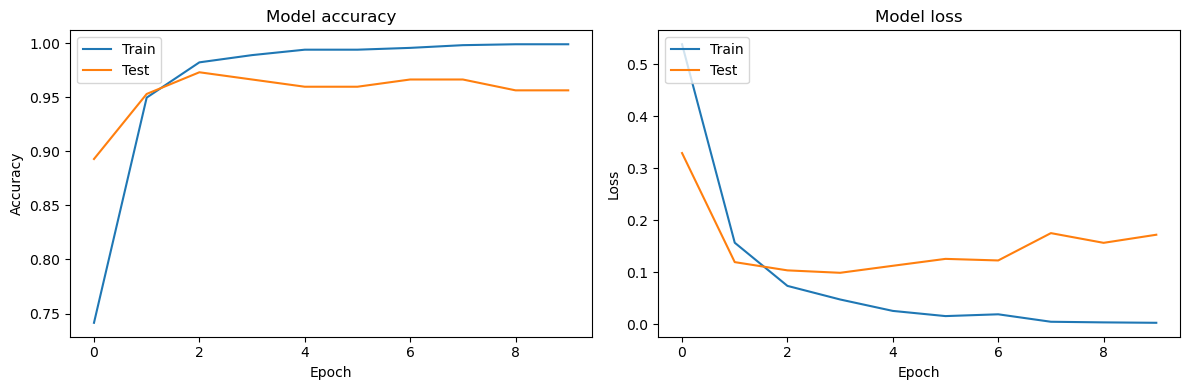

In [20]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_sequences, y_test)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

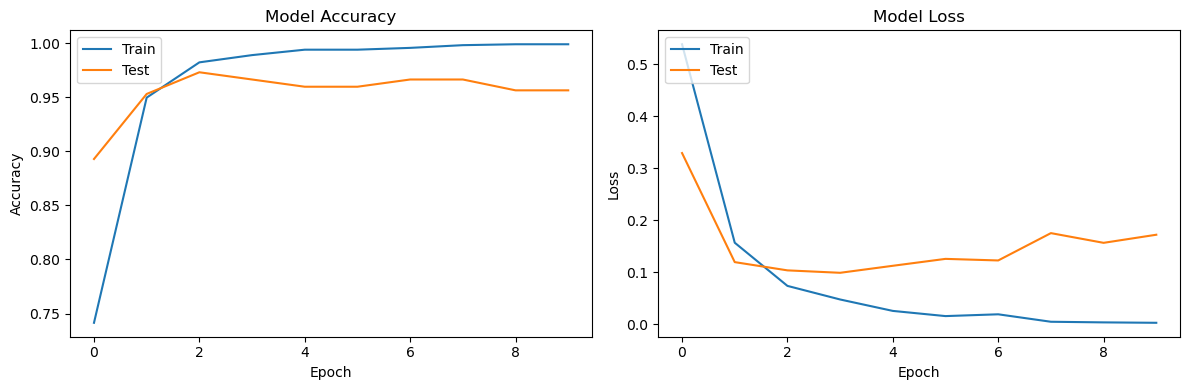

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [22]:
def predict_spam(message):
    # Create a sequence for the new message
    sequence = tokenizer.texts_to_sequences([message])
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    # Make a prediction
    prediction = model.predict(padded_sequence)
    # Interpret the prediction
    if prediction[0] > 0.5:
        print(f"'{message}'\n   -> This is likely SPAM (Score: {prediction[0][0]:.2f})")
    else:
        print(f"'{message}'\n   -> This is likely HAM (Score: {prediction[0][0]:.2f})")

# Test with some example messages
predict_spam("Congratulations! You've won a $1,000 gift card. Click this link to claim now!")
predict_spam("Hey, are we still on for lunch tomorrow?")
predict_spam("URGENT: Your account has been suspended. Please log in here to fix it.")
predict_spam("Can you pick up some milk on your way home?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
'Congratulations! You've won a $1,000 gift card. Click this link to claim now!'
   -> This is likely SPAM (Score: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
'Hey, are we still on for lunch tomorrow?'
   -> This is likely HAM (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
'URGENT: Your account has been suspended. Please log in here to fix it.'
   -> This is likely SPAM (Score: 0.98)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
'Can you pick up some milk on your way home?'
   -> This is likely HAM (Score: 0.00)


In [23]:
import pickle

# Save the trained model to a file
model.save('spam_model.keras')

# Save the tokenizer object to a file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ Model and tokenizer have been saved successfully!")

✅ Model and tokenizer have been saved successfully!
